#20 NEWS GROUP CLASSIFICATION  

Corrado Montoro 

Luca Lazzati

In [3]:
pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.9MB/s 
     |████████████████████████████████| 552kB 45.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=4ca2efb2108630b0a26bd012158454b496f013b633513e3af3b07acb356173f6
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=930b845f8c4bd8161b1297c0ac8c5d3d2d84f08abdd10a32420e5d0537b29843
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [5]:
import os
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection, preprocessing
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import pyLDAvis
import pyLDAvis.sklearn


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Parsing dei file

In [0]:
flist = [os.path.join(path, name) for path, subdirs, files in os.walk("/content/drive/My Drive/20_newsgroups") for name in files] 
text = []
diz = {}
for si in range(len(flist)):
    filein = flist[si]
    ls_filein = filein.split('/')
    target = ls_filein[5].split('\\')[0]
    ind = ls_filein[6].split('\\')[-1]
    with open(filein) as f: data = f.readlines()
    text = None
    for j in range(len(data)):
        if (data[j] == '\n'):
            text = data[j+1:]
            for k in range(len(text)):
                if ('Version:' in text[k]):
                    text = text[k+1:]
                    break;
                elif ('writes' in text[k]):
                    text = text[k+1:]
                    break;
                elif ('wrotes' in text[k]):
                    text = text[k+1:]
                    break;
                elif (text[k] == '\n' and text[k-1] =='\n'):
                    text = text[k+1:]
                    break;
            break;
    diz[int(si)] = {'text':text, 'target':target, 'idx':int(ind)}
    
df = pd.DataFrame.from_dict(diz, orient = 'index')

In [0]:
df.to_csv("DataTextMiningAll.csv")

# RACCOLTA DEI FILE

doc: tutti i file con i vari testi

classe: target dei file

idx: indice dei vari file

In [0]:
df = pd.read_csv('/content/drive/My Drive/DataTextMiningAll.csv')  

In [0]:
df.head()

,Unnamed: 0,text,target,idx
0,0,['>In article <Apr.7.01.56.56.1993.22824@athos...,soc.religion.christian,20487
1,1,['I have come across what I consider to be an ...,soc.religion.christian,20488
2,2,"['Hi...\n', '\n', ""I'm new to this group, and ...",soc.religion.christian,20362
3,3,"['Therefore, whoever humbles himself like this...",soc.religion.christian,20365
4,4,['>In article <Mar.22.02.52.49.1993.330@athos....,soc.religion.christian,20361


Eliminazione della colonna **Unnamed: 0**

In [0]:
df.drop(columns={"Unnamed: 0": ""},inplace=True)

Visualizzazione 

In [0]:
df.head()

,text,target,idx
0,['>In article <Apr.7.01.56.56.1993.22824@athos...,soc.religion.christian,20487
1,['I have come across what I consider to be an ...,soc.religion.christian,20488
2,"['Hi...\n', '\n', ""I'm new to this group, and ...",soc.religion.christian,20362
3,"['Therefore, whoever humbles himself like this...",soc.religion.christian,20365
4,['>In article <Mar.22.02.52.49.1993.330@athos....,soc.religion.christian,20361


# Data exploration

Esempio di news

In [0]:
print(df.text.loc[60])

['> Since the_day_upon_which_most_Christians_celebrate_the_resurrection_of_Jesus\n', '> is approaching, I thought I would comment on this:\n', '> \n', '> In article <Mar.29.03.23.31.1993.19711@athos.rutgers.edu> dsegard@nyx.cs.du.edu (Daniel Segard) writes:\n', '> >\n', '> What is the objection to celebration of Easter?  It is celebration of the\n', "> resurrection of Jesus.  I don't recall a command in Scripture for us to\n", '> celebrate the resurrection, but it is the sole and only reason that we\n', '> are Christians--how could we not celebrate it?  If it is only the name\n', '\n', 'Not quite correct.  Biblical teaching expects us to celebrate the\n', 'resurrection of Christ not once a year but every time someone is baptized.\n', ' Col. 2:12-Buried with him in baptism, wherein also ye are risen with him\n', 'through the faith of the operation of God, who hath raised him from the\n', 'dead."  Rom. 6:4-Therefore we are buried with him in baptism into death:\n', 'that like as Christ w

Controlliamo se sono presenti **na**

In [0]:
df.isnull().sum()

text      0
target    0
idx       0
dtype: int64

Lista delle classi

In [0]:
print(df.target.unique())

['soc.religion.christian' 'talk.politics.mideast' 'sci.electronics'
 'talk.politics.guns' 'talk.religion.misc' 'talk.politics.misc'
 'rec.sport.hockey' 'sci.space' 'sci.med' 'sci.crypt' 'alt.atheism'
 'comp.sys.mac.hardware' 'misc.forsale' 'rec.sport.baseball' 'rec.autos'
 'comp.sys.ibm.pc.hardware' 'rec.motorcycles' 'comp.graphics'
 'comp.os.ms-windows.misc' 'comp.windows.x']


Creare una nuova colonna "Target" con valori interi dalla colonna "Target_Num" per poi visualizzare le varie categorie

In [0]:
df['target_num'] = df['target']
target = {'alt.atheism':0, 'comp.graphics':1, 'comp.os.ms-windows.misc':2, 'comp.sys.ibm.pc.hardware':3, 'comp.sys.mac.hardware':4, 'comp.windows.x':5, 'misc.forsale':6, 'rec.autos':7,'rec.motorcycles':8,'rec.sport.baseball':9,'rec.sport.hockey':10,'sci.crypt':11,'sci.electronics':12,'sci.med':13,'sci.space':14,'soc.religion.christian':15,'talk.politics.guns':16,'talk.politics.mideast':17,'talk.politics.misc':18,'talk.religion.misc':19}
df['target_num'] = df['target_num'].apply(lambda a: target.get(a) if a in target else a)

Si controllano le varie classi se sono bilanciate

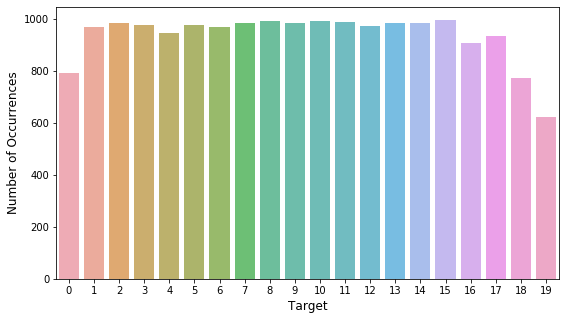

In [0]:
import seaborn as sns
count_cl = df['target_num'].value_counts()

plt.figure(figsize=(9,5))
sns.barplot(count_cl.index, count_cl.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target', fontsize=12);

# PRE-PROCESSING

Per il pre-processing abbiamo svolto le seguenti azioni:

- Conversione del testo in minuscolo
- Eliminazione indirizzi mail
- Eliminazione numeri
- Eliminazione caratteri di punteggiatura
- Rimozione parole composta da una e due lettere
- Sistemazione degli spazi che si sono creati con le precedenti operazioni

In [0]:
# Trasformazione in lower-case
df['text_processed'] = df['text'].map(lambda x: x.lower())

# Rimozione indirizzi email
df['text_processed'] = df['text_processed'].apply(lambda x: re.sub('\w+@\w+\.\w+?', '', x))

# Rimozione numeri
df['text_processed'] = df['text_processed'].apply(lambda x: re.sub('\d','', x))

# Rimozione della punteggiatura
df['text_processed']  = df['text_processed'].apply(lambda x: re.sub(r'[^\w\s]','', x))

# Rimozione parole composte
df['text_processed']  = df['text_processed'].astype(str).map(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

# Rimozione spazi
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

#rimozione spazi di inizio riga
df['text_processed'] = df['text_processed'].map(lambda x: x.lstrip()) 

#rimozione spazi di fine riga
df['text_processed'] = df['text_processed'].map(lambda x: x.rstrip()) 

# TOKENIZZAZIONE TESTO


In [0]:
df['text_processed'] = df['text_processed'].apply(nltk.tokenize.word_tokenize)

In [0]:
df.head()

,text,target,idx,target_num,text_processed
0,['>In article <Apr.7.01.56.56.1993.22824@athos...,soc.religion.christian,20487,15,"[article, aprutgersedu, chpcomn, matt, therefo..."
1,['I have come across what I consider to be an ...,soc.religion.christian,20488,15,"[have, come, across, what, consider, excellent..."
2,"['Hi...\n', '\n', ""I'm new to this group, and ...",soc.religion.christian,20362,15,"[hin, new, this, group, and, maybe, this, has,..."
3,"['Therefore, whoever humbles himself like this...",soc.religion.christian,20365,15,"[therefore, whoever, humbles, himself, like, t..."
4,['>In article <Mar.22.02.52.49.1993.330@athos....,soc.religion.christian,20361,15,"[article, marutgersedu, sugaedu, terrance, hea..."


# STOP-WORDS

Vengono eliminate le stopwords

In [0]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','one','would']) #aggiunta a mano di stop_words

def remove_stopwords(serie):
    return [word for word in serie if word not in stop_words]

# Rimozione stopwords
df['text_processed'] = df['text_processed'].apply(remove_stopwords)

In [0]:
df.head()

,text,target,idx,target_num,text_processed
0,['>In article <Apr.7.01.56.56.1993.22824@athos...,soc.religion.christian,20487,15,"[article, aprutgersedu, chpcomn, matt, therefo..."
1,['I have come across what I consider to be an ...,soc.religion.christian,20488,15,"[come, across, consider, excellent, tract, bit..."
2,"['Hi...\n', '\n', ""I'm new to this group, and ...",soc.religion.christian,20362,15,"[hin, new, group, maybe, covered, alreadyn, an..."
3,"['Therefore, whoever humbles himself like this...",soc.religion.christian,20365,15,"[therefore, whoever, humbles, like, child, gre..."
4,['>In article <Mar.22.02.52.49.1993.330@athos....,soc.religion.christian,20361,15,"[article, marutgersedu, sugaedu, terrance, hea..."


# LEMMATIZZAZIONE E STEMMATIZZAZIONE

Si procede alla lemmatization e allo stemming (utilizzando l'algoritmo di Porter) del testo, tenendo separate le due operazioni:

In [0]:
def lemmatization(serie):
    return [WordNetLemmatizer().lemmatize(str(word)) for word in serie]

df['token_lem'] = df['text_processed'].apply(lemmatization)

def stemming(serie):
    return [PorterStemmer().stem(str(word)) for word in serie]

df['token_stem'] = df['text_processed'].apply(stemming)

In [0]:
df.head()

,text,target,idx,target_num,text_processed,token_lem,token_stem
0,['>In article <Apr.7.01.56.56.1993.22824@athos...,soc.religion.christian,20487,15,"[article, aprutgersedu, chpcomn, matt, therefo...","[article, aprutgersedu, chpcomn, matt, therefo...","[articl, aprutgersedu, chpcomn, matt, therefor..."
1,['I have come across what I consider to be an ...,soc.religion.christian,20488,15,"[come, across, consider, excellent, tract, bit...","[come, across, consider, excellent, tract, bit...","[come, across, consid, excel, tract, bit, leng..."
2,"['Hi...\n', '\n', ""I'm new to this group, and ...",soc.religion.christian,20362,15,"[hin, new, group, maybe, covered, alreadyn, an...","[hin, new, group, maybe, covered, alreadyn, an...","[hin, new, group, mayb, cover, alreadyn, anybo..."
3,"['Therefore, whoever humbles himself like this...",soc.religion.christian,20365,15,"[therefore, whoever, humbles, like, child, gre...","[therefore, whoever, humbles, like, child, gre...","[therefor, whoever, humbl, like, child, greate..."
4,['>In article <Mar.22.02.52.49.1993.330@athos....,soc.religion.christian,20361,15,"[article, marutgersedu, sugaedu, terrance, hea...","[article, marutgersedu, sugaedu, terrance, hea...","[articl, marutgersedu, sugaedu, terranc, heath..."


Per avere un quadro più completo viene presa in esame anche la rappresentazione bigram, sia per i token stem e lem:

In [0]:
def bigram(token):
    bi = []
    for i in range(1,len(token)):
        bi.append(token[i-1] + ' ' + token[i])
    return(bi)

df['bigram_stem'] = df['token_stem'].apply(bigram)
df['bigram_lem'] = df['token_lem'].apply(bigram)

In [0]:
df.head()

,text,target,idx,target_num,text_processed,token_lem,token_stem,bigram_stem,bigram_lem
0,['>In article <Apr.7.01.56.56.1993.22824@athos...,soc.religion.christian,20487,15,"[article, aprutgersedu, chpcomn, matt, therefo...","[article, aprutgersedu, chpcomn, matt, therefo...","[articl, aprutgersedu, chpcomn, matt, therefor...","[articl aprutgersedu, aprutgersedu chpcomn, ch...","[article aprutgersedu, aprutgersedu chpcomn, c..."
1,['I have come across what I consider to be an ...,soc.religion.christian,20488,15,"[come, across, consider, excellent, tract, bit...","[come, across, consider, excellent, tract, bit...","[come, across, consid, excel, tract, bit, leng...","[come across, across consid, consid excel, exc...","[come across, across consider, consider excell..."
2,"['Hi...\n', '\n', ""I'm new to this group, and ...",soc.religion.christian,20362,15,"[hin, new, group, maybe, covered, alreadyn, an...","[hin, new, group, maybe, covered, alreadyn, an...","[hin, new, group, mayb, cover, alreadyn, anybo...","[hin new, new group, group mayb, mayb cover, c...","[hin new, new group, group maybe, maybe covere..."
3,"['Therefore, whoever humbles himself like this...",soc.religion.christian,20365,15,"[therefore, whoever, humbles, like, child, gre...","[therefore, whoever, humbles, like, child, gre...","[therefor, whoever, humbl, like, child, greate...","[therefor whoever, whoever humbl, humbl like, ...","[therefore whoever, whoever humbles, humbles l..."
4,['>In article <Mar.22.02.52.49.1993.330@athos....,soc.religion.christian,20361,15,"[article, marutgersedu, sugaedu, terrance, hea...","[article, marutgersedu, sugaedu, terrance, hea...","[articl, marutgersedu, sugaedu, terranc, heath...","[articl marutgersedu, marutgersedu sugaedu, su...","[article marutgersedu, marutgersedu sugaedu, s..."


# CLASSIFICAZIONE

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df,df['target'],test_size = 0.2, stratify=df['target'])

# MATRICI

Partendo dai token lem e stem e dalle matrici unigram e bigram si procede a calcolare, per ogni combinazione:
- Pesi TF
- Pesi TF-IDF
- Pesi Binari

Inoltre si utilizza un token_pattern in modo da prendere in considerazione solamente parole di lunghezza > 2

In [0]:
# Funzione per utilizzare le tokenizzazioni già svolte
def identity_tokenizer(text):
    return text

In [0]:
# Vettorizzatore per pesi TF-IDF
tfidf = TfidfVectorizer(
    analyzer='word',
    min_df=10,
    lowercase=True,
    tokenizer=identity_tokenizer,
    preprocessor=identity_tokenizer,
    token_pattern='[a-zA-Z0-9]{3,}')

# Vettorizzatore per pesi TF
count = CountVectorizer(
    analyzer='word',
    min_df=10,
    lowercase=True,
    tokenizer=identity_tokenizer,
    preprocessor=identity_tokenizer,
    token_pattern='[a-zA-Z0-9]{3,}') 

# Vettorizzatore per pesi binari
binary = CountVectorizer(
    analyzer='word',
    min_df=10,
    binary=True,
    tokenizer=identity_tokenizer,
    preprocessor=identity_tokenizer,
    token_pattern='[a-zA-Z0-9]{3,}') 

# Funzione che crea la vettorizzazione partendo dalla matrice train e la applica su quella test corrispondente
def create_matrix(token_train,token_test,vectorizer):
    ls = []
    for vett in vectorizer:
        for i in zip(token_train,token_test):
            train = vett.fit_transform(i[0])
            test = vett.transform(i[1])
            ls.append((train,test))
    return ls

matrix = create_matrix([x_train['token_stem'],x_train['bigram_stem'],x_train['token_lem'],x_train['bigram_lem']], [x_test['token_stem'],x_test['bigram_stem'],x_test['token_lem'],x_test['bigram_lem']], [tfidf,count,binary])

Otteniamo 24 matrici, 12 di train e 12 di test:

- Unigram - tf-idf - stem
- Unigram - tf-idf - lem
- Unigram - tf - stem
- Unigram - tf - lem
- Unigram - binary - stem
- Unigram - binary - lem

- Bigram - tf-idf - stem
- Bigram - tf-idf - lem
- Bigram - tf - stem
- Bigram - tf - lem
- Bigram - binary - stem
- Bigram - binary - lem


# FEATURE SELECTION





Utilizzando il test del chi-quadro si ottiene una feature selection si tengono solo le prime 5000 features (per ogni matrice) ordinate in ordine decrescente in base al valore del test. 
<br>
L'operazione di feature selection viene giustificata perchè:
- Si riduce il rischio di overfitting
- Eliminazione degli features irrilevanti e quindi potenzialmente migliora le performance dei modelli
- Permette di addestrare modelli utilizzando minor sforzo computazionale

In [0]:
def feature_selection(ls_mat):
    matrix_train=ls_mat[0]
    matrix_test=ls_mat[1]
    kb=SelectKBest(chi2, k=5000)
    kb.fit_transform(matrix_train, y_train)
    train=pd.DataFrame((kb.fit_transform(matrix_train, y_train)).toarray())
    test=pd.DataFrame((kb.transform(matrix_test)).toarray())
    return((train,test))

Per comodità le matrici vengono salvate in un dizionario, la chiave corrisponde al nome della matrice e il valore ad una tupla contente la matrice di train e quella di test corrispondenti alla chiave:

In [0]:
names = ['unigram_tfidf_stem','bigram_tfidf_stem','unigram_tfidf_lem','bigram_tfidf_lem','unigram_count_stem','bigram_count_stem','unigram_count_lem','bigram_count_lem','unigram_binary_stem','bigram_binary_stem','unigram_binary_lem','bigram_binary_lem']

dict_matrix = {}
for i in range(len(matrix)):
    dict_matrix[names[i]] = feature_selection(matrix[i])

# MODELLISTICA

I classificatori scelti, considerando la letteratura e lo sforzo computazionale, sono:

- Naive Bayes
- Random Forest
- Regressione logistica

Ogni modello viene addestrato con diversi iper-parametri sul dataset di training e successivamente viene testato sui dati di test:

In [0]:
dict_classificators=  {'Naive Bayes':MultinomialNB(),'Random Forest':RandomForestClassifier(max_features='log2'),'Reg Log':LogisticRegression(multi_class='multinomial', n_jobs=-1)}

In [0]:
diz_results = {}
for classificator in dict_classificators:
  for matrix in dict_matrix:
    type_matrix = matrix.split('_')[0]
    weight = matrix.split('_')[1]
    token = matrix.split('_')[2]
    parameters = {'Naive Bayes':{'alpha':[0.1,0.5,1]},'Random Forest':{'criterion':['gini','entropy'],'n_estimators':[100,200], 'max_depth':[5,10,20]},'Reg Log':{'solver':['lbfgs','saga'],'max_iter':[5,10,15]} }
    grid_obj = GridSearchCV(dict_classificators[classificator], parameters[classificator], cv=5, n_jobs=-1).fit(dict_matrix[matrix][0], y_train)
    accuracy_train = grid_obj.best_score_
    clf = grid_obj.best_estimator_
    clf.fit(dict_matrix[matrix][0], y_train)
    predictions = clf.predict(dict_matrix[matrix][1])
    accuracy_test = accuracy_score(y_test, predictions)
    diz_results[str(matrix)+';'+str(classificator)]={'tipo_matrice':type_matrix,'peso':weight, 'token':token, 'classificatore':classificator,'accuracy_train_cv':accuracy_train, 'accuracy_test':accuracy_test}

ris = pd.DataFrame.from_dict(diz_results, orient='index').reset_index()

# Si esportano i risultati in un file csv
ris.to_csv('Risultati.csv')

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be 

In [7]:
risultati = pd.read_excel('/content/drive/My Drive/RisultatiFinale.xlsx')
risultati.head()

,index,tipo_matrice,peso,token,classificatore,accuracy_train_cv,accuracy_test
0,unigram_tfidf_stem_Naive Bayes,unigram,tfidf,stem,Naive Bayes,0.797267,0.776860
1,bigram_tfidf_stem_Naive Bayes,bigram,tfidf,stem,Naive Bayes,0.603867,0.565449
2,unigram_tfidf_lem_Naive Bayes,unigram,tfidf,lem,Naive Bayes,0.795800,0.781925
3,bigram_tfidf_lem_Naive Bayes,bigram,tfidf,lem,Naive Bayes,0.593667,0.556918
4,unigram_count_stem_Naive Bayes,unigram,count,stem,Naive Bayes,0.770533,0.760064


Il tipo di rappresentazione mediamente più performante è decisamente quella unigram

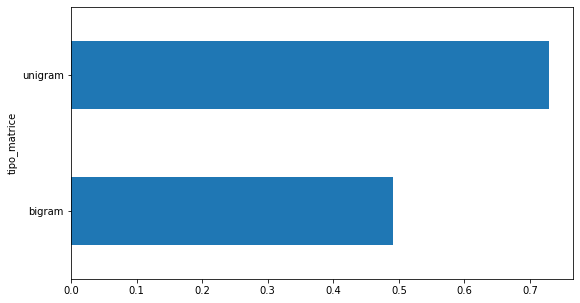

In [8]:
groups = risultati.groupby('tipo_matrice')['accuracy_test'].mean()
plt.figure(figsize=(9,5))
ax = groups.plot.barh(x='accuracy_test', y='tipo_matrice')

Non sembra esserci mediamente grossa distinzione tra i tre pesi, il più performante risulta quello tfidf

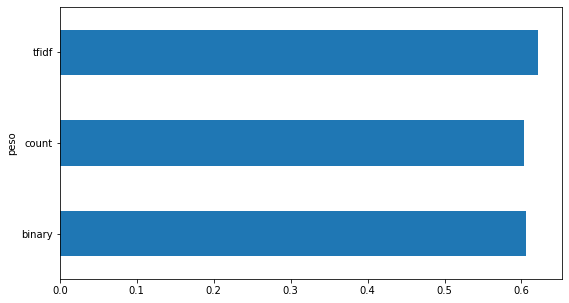

In [9]:
groups= risultati.groupby('peso')['accuracy_test'].mean()
plt.figure(figsize=(9,5))
ax = groups.plot.barh(x='accuracy_test', y='peso')

Mediamente l'operazione di stemming aumenta l'accuracy di 0.6 punti percentuali

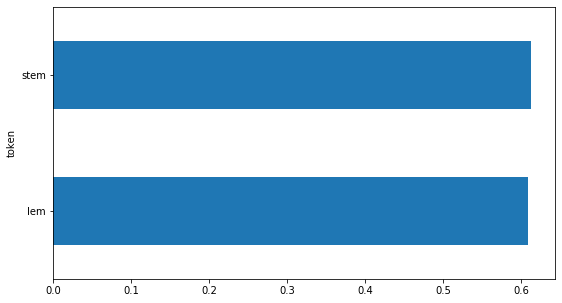

In [10]:
groups=risultati.groupby('token')['accuracy_test'].mean()
plt.figure(figsize=(9,5))
ax = groups.plot.barh(x='accuracy_test', y='token')

Il classificatore mediamente più performante è il MultiNomial NB, segue la regressione logisticsa e con notevole distacco la random forest

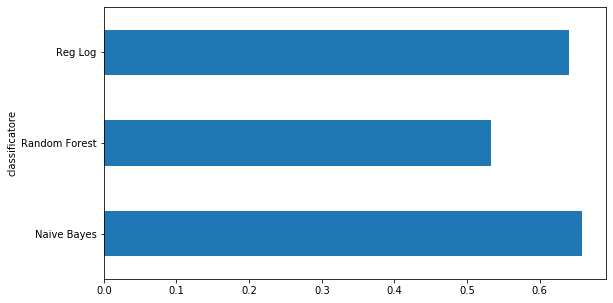

In [0]:
groups=risultati.groupby('classificatore')['accuracy_test'].mean()
plt.figure(figsize=(9,5))
ax = groups.plot.barh(x='accuracy_test', y='classificatore')

Il multinomial naive bayes e la regressione logistica ottengono un'accuracy superiore al 75% utilizzando le due matrici unigram con pesi tfidf:

In [12]:
risultati.sort_values('accuracy_test', ascending=False)

,index,tipo_matrice,peso,token,classificatore,accuracy_train_cv,accuracy_test
2,unigram_tfidf_lem_Naive Bayes,unigram,tfidf,lem,Naive Bayes,0.795800,0.781925
0,unigram_tfidf_stem_Naive Bayes,unigram,tfidf,stem,Naive Bayes,0.797267,0.776860
8,unigram_binary_stem_Naive Bayes,unigram,binary,stem,Naive Bayes,0.776667,0.772594
10,unigram_binary_lem_Naive Bayes,unigram,binary,lem,Naive Bayes,0.775400,0.768595
26,"unigram_tfidf_lem,Reg Log",unigram,tfidf,lem,Reg Log,0.776067,0.766729
24,unigram_tfidf_stem_Reg Log,unigram,tfidf,stem,Reg Log,0.778733,0.762730
6,unigram_count_lem_Naive Bayes,unigram,count,lem,Naive Bayes,0.771333,0.762463
4,unigram_count_stem_Naive Bayes,unigram,count,stem,Naive Bayes,0.770533,0.760064
30,unigram_count_lem_Reg Log,unigram,count,lem,Reg Log,0.741267,0.738470
28,unigram_count_stem_Reg Log,unigram,count,stem,Reg Log,0.736800,0.735004


# TOPIC MODELLING

# LDA Unigram - tf-idf - lem 

In [0]:
data_token_lem_tfidf = tfidf.fit_transform(df.token_lem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_token_lem_tfidf)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_token_lem_tfidf))

Best Model Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -278073.29354869557
Model Perplexity:  14856.56428175412


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_token_lem_tfidf, tfidf, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  47.312551
1       51.163364 -159.968018       2        1  35.755255
0      -73.144554   21.523815       3        1   9.385046
4      -66.410133 -110.606438       4        1   4.223582
3       54.417324   12.443444       5        1   3.323567, topic_info=      Category        Freq       Term       Total  loglift  logprob
6470   Default  140.000000        god  140.000000  30.0000  30.0000
2617   Default   71.000000  christian   71.000000  29.0000  29.0000
8131   Default   58.000000      jesus   58.000000  28.0000  28.0000
16814  Default  148.000000     window  148.000000  27.0000  27.0000
2634   Default   48.000000     church   48.000000  26.0000  26.0000
...        ...         ...        ...         ...      ...      ...
4814    Topic5    6.817938      earth   35.464545   1.7552  -6.4041
14175   Topic5    7.734912      space   70.682593   1.1917  -6.2779
2882    Topic5    4.618002  collision    7.507817   2.9181  -6.7937
9631    Topic5    5.066739    mission   19.868402   2.0377  -6.7009
15866   Topic5    4.516423    turkish   31.370873   1.4660  -6.8159

[346 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
316        1  0.016483  advancen
316        2  0.972473  advancen
423        5  0.938199  aidernet
540        1  0.431457      also
540        2  0.480072      also
...      ...       ...       ...
17089      1  0.753367      year
17089      2  0.215248      year
17089      3  0.026906      year
17089      4  0.006726      year
17171      5  0.948978  zoologyn

[649 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 4])

# LDA Unigram - tf-idf - stem

In [0]:
data_token_stem_tfidf = tfidf.fit_transform(df.token_stem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_token_stem_tfidf)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_token_stem_tfidf))

Best Model Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -268569.82174257614
Model Perplexity:  11741.898531961233


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_token_stem_tfidf, tfidf, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  55.526956
3       51.163364 -159.968018       2        1  27.734930
1      -73.144554   21.523815       3        1   7.540209
0      -66.410133 -110.606438       4        1   5.915883
4       54.417324   12.443444       5        1   3.282023, topic_info=      Category        Freq       Term       Total  loglift  logprob
5351   Default  146.000000        god  146.000000  30.0000  30.0000
14332  Default  151.000000     window  151.000000  29.0000  29.0000
2266   Default   94.000000  christian   94.000000  28.0000  28.0000
4759   Default  123.000000       file  123.000000  27.0000  27.0000
11037  Default  132.000000        run  132.000000  26.0000  26.0000
...        ...         ...        ...         ...      ...      ...
13464   Topic5    7.068507     turkey   16.950664   2.5421  -6.3435
1138    Topic5    8.058239       bank   28.777219   2.1438  -6.2125
10560   Topic5    6.400475     region   17.827762   2.3923  -6.4428
11959   Topic5    5.949751     soviet   14.149636   2.5504  -6.5158
11922   Topic5    5.831565       soon   34.543391   1.6378  -6.5359

[369 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
181        3  0.812702  actusorgn
239        1  0.063499   advancen
239        2  0.825482   advancen
239        4  0.095248   advancen
375        1  0.029777  algorithm
...      ...       ...        ...
14582      2  0.139156       year
14582      3  0.006626       year
14582      4  0.006626       year
14654      3  0.909129    zionism
14663      4  0.886001   zoologyn

[688 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 5])

# LDA Bigram - tf-idf - stem


In [0]:
data_bigram_stem_tfidf = tfidf.fit_transform(df.bigram_stem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_bigram_stem_tfidf)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_bigram_stem_tfidf))

Best Model Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -159556.29495471856
Model Perplexity:  32055.44791329295


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_bigram_stem_tfidf, tfidf, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  22.982631
0       51.163364 -159.968018       2        1  20.985512
2      -73.144554   21.523815       3        1  20.033684
3      -66.410133 -110.606438       4        1  20.001324
4       54.417324   12.443444       5        1  15.996849, topic_info=      Category       Freq                Term       Total  loglift  logprob
10509  Default  17.000000          sourc code   17.000000  30.0000  30.0000
5272   Default  16.000000  institut technolog   16.000000  29.0000  29.0000
107    Default  15.000000          activ netn   15.000000  28.0000  28.0000
211    Default  15.000000         alink ksand   15.000000  27.0000  27.0000
8687   Default  15.000000        privat activ   15.000000  26.0000  26.0000
...        ...        ...                 ...         ...      ...      ...
6022    Topic5   9.381351          law enforc   24.368776   0.8782  -6.8918
8436    Topic5   9.380820         pleas email   59.987849  -0.0227  -6.8918
2879    Topic5   9.582625           dont know  114.940820  -0.6517  -6.8705
2924    Topic5   8.958209          dont think   73.028887  -0.2655  -6.9379
567     Topic5   8.955597          anyon know  118.239358  -0.7477  -6.9382

[307 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
0          2  0.325350        ___ ___
0          4  0.455490        ___ ___
0          5  0.195210        ___ ___
12         4  0.914523      ____ ____
16         2  0.186170    _____ _____
...      ...       ...            ...
13228      3  0.117119       year old
13228      4  0.117119       year old
13228      5  0.292798       year old
13264      1  0.885079    york replac
13340      2  0.980340  zoologyn kipl

[505 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5])

# LDA Bigram - tf-idf - lem

In [0]:
data_bigram_lem_tfidf = tfidf.fit_transform(df.bigram_lem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_bigram_lem_tfidf)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_bigram_lem_tfidf))

Best Model Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -148064.30547586092
Model Perplexity:  26597.054426887567


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_bigram_lem_tfidf, tfidf, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  21.379146
1       51.163364 -159.968018       2        1  21.206433
4      -73.144554   21.523815       3        1  20.488781
0      -66.410133 -110.606438       4        1  20.210711
3       54.417324   12.443444       5        1  16.714929, topic_info=      Category       Freq                  Term       Total  loglift  logprob
7557   Default  40.000000          please reply   40.000000  30.0000  30.0000
10975  Default  29.000000            video card   29.000000  29.0000  29.0000
7535   Default  63.000000          please email   63.000000  28.0000  28.0000
7546   Default  26.000000            please let   26.000000  27.0000  27.0000
0      Default  31.000000               ___ ___   31.000000  26.0000  26.0000
...        ...        ...                   ...         ...      ...      ...
506     Topic5   8.443653           anyone give   11.883760   1.4471  -6.9798
2548    Topic5  11.037523             dont know  124.377987  -0.6332  -6.7119
4083    Topic5   9.376764  greatly appreciatedn   28.508907   0.6769  -6.8750
8224    Topic5   8.652179              red wing   16.645637   1.1345  -6.9554
4890    Topic5   8.777267              ive seen   53.048693  -0.0102  -6.9411

[303 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
0          2  0.312803          ___ ___
0          3  0.688167          ___ ___
12         3  0.961899        ____ ____
16         2  0.971007      _____ _____
83         5  0.969044      access time
...      ...       ...              ...
11714      3  0.162871         year old
11714      4  0.190016         year old
11714      5  0.190016         year old
11732      1  0.893869  yeast infection
11826      3  0.922001     yoursn james

[474 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

# LDA Unigram - tf - lem


In [0]:
data_token_lem_tf = count.fit_transform(df.token_lem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_token_lem_tf)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_token_lem_tf))

Best Model Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -3529869.1923194556
Model Perplexity:  3926.4049311933136


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_token_lem_tf, count, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  27.669867
3       51.163364 -159.968018       2        1  20.661608
1      -73.144554   21.523815       3        1  20.057058
2      -66.410133 -110.606438       4        1  17.407443
0       54.417324   12.443444       5        1  14.204024, topic_info=      Category         Freq  ...  loglift  logprob
6470   Default  4127.000000  ...  30.0000  30.0000
9299   Default  3236.000000  ...  29.0000  29.0000
5784   Default  3433.000000  ...  28.0000  28.0000
6272   Default  2450.000000  ...  27.0000  27.0000
6520   Default  2578.000000  ...  26.0000  26.0000
...        ...          ...  ...      ...      ...
16633   Topic5   718.984874  ...   0.1044  -5.9614
540     Topic5   727.840915  ...  -0.1566  -5.9491
16923   Topic5   677.949708  ...   0.2346  -6.0201
5301    Topic5   681.775360  ...   0.0416  -6.0145
6390    Topic5   698.439846  ...  -0.4347  -5.9903

[447 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
213        1  0.198341   action
213        2  0.046605   action
213        3  0.032515   action
213        4  0.556004   action
213        5  0.166910   action
...      ...       ...      ...
17089      3  0.345740     year
17089      4  0.117512     year
17089      5  0.241163     year
17163      4  0.993915  zionism
17165      4  0.996239  zionist

[964 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 1])

# LDA Unigram - tf - stem

In [0]:
data_token_stem_tf = count.fit_transform(df.token_stem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_token_stem_tf)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_token_stem_tf))

Best Model Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -3480440.2826417
Model Perplexity:  3066.1466537036144


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_token_stem_tf, count, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  28.784030
1       51.163364 -159.968018       2        1  20.752607
2      -73.144554   21.523815       3        1  20.299684
3      -66.410133 -110.606438       4        1  15.934526
4       54.417324   12.443444       5        1  14.229153, topic_info=      Category         Freq  ...  loglift  logprob
7809   Default  3258.000000  ...  30.0000  30.0000
4759   Default  3507.000000  ...  29.0000  29.0000
5351   Default  4101.000000  ...  28.0000  28.0000
14332  Default  3006.000000  ...  27.0000  27.0000
6177   Default  2135.000000  ...  26.0000  26.0000
...        ...          ...  ...      ...      ...
9781    Topic5   894.810774  ...   0.6865  -5.7609
7038    Topic5  1020.269411  ...  -0.1004  -5.6297
7361    Topic5   978.145285  ...  -0.2641  -5.6719
8488    Topic5   893.902106  ...   0.3879  -5.7619
13148   Topic5   880.741658  ...   0.0724  -5.7768

[450 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
114        1  0.741637  accept
114        2  0.096243  accept
114        3  0.015367  accept
114        4  0.056614  accept
114        5  0.088964  accept
...      ...       ...     ...
14582      1  0.115195    year
14582      2  0.308853    year
14582      3  0.496860    year
14582      4  0.041948    year
14582      5  0.036949    year

[1055 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

# LDA Bigram - tf - lem

In [0]:
data_bigram_lem_tf = count.fit_transform(df.bigram_lem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_bigram_lem_tf)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_bigram_lem_tf))

Best Model Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -589072.9675981455
Model Perplexity:  7018.767824777479


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_bigram_lem_tf, count, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  25.782692
4       51.163364 -159.968018       2        1  21.833265
0      -73.144554   21.523815       3        1  21.037825
3      -66.410133 -110.606438       4        1  17.619056
2       54.417324   12.443444       5        1  13.727162, topic_info=      Category         Freq  ...  loglift  logprob
6066   Default  2553.000000  ...  30.0000  30.0000
516    Default   560.000000  ...  29.0000  29.0000
9938   Default   336.000000  ...  28.0000  28.0000
1677   Default   229.000000  ...  27.0000  27.0000
5365   Default   277.000000  ...  26.0000  26.0000
...        ...          ...  ...      ...      ...
649     Topic5    79.738552  ...   1.9762  -6.0850
5664    Topic5   100.477380  ...   1.9283  -5.8538
6761    Topic5   134.691401  ...   0.6330  -5.5608
11596   Topic5    87.071460  ...   1.7067  -5.9970
8598    Topic5    88.255891  ...   1.3983  -5.9835

[294 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
0          2  0.992617    ___ ___
1          2  0.979996   ___ ____
2          2  0.982704  ___ _____
11         1  0.026548   ____ ___
11         2  0.955736   ____ ___
...      ...       ...        ...
11687      1  0.214466   year ago
11687      2  0.328133   year ago
11687      3  0.184441   year ago
11687      4  0.154415   year ago
11687      5  0.117956   year ago

[473 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])

# LDA Bigram - tf - stem

In [0]:
data_bigram_stem_tf = count.fit_transform(df.bigram_stem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_bigram_stem_tf)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_bigram_stem_tf))

Best Model Params:  {'learning_decay': 0.7, 'n_components': 5}
Best Log Likelihood Score:  -664554.8553902761
Model Perplexity:  8481.898621352602


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_bigram_stem_tf, count, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  24.807001
2       51.163364 -159.968018       2        1  21.476585
4      -73.144554   21.523815       3        1  19.906941
3      -66.410133 -110.606438       4        1  17.227036
1       54.417324   12.443444       5        1  16.582437, topic_info=      Category         Freq  ...  loglift  logprob
6813   Default  2502.000000  ...  30.0000  30.0000
567    Default   571.000000  ...  29.0000  29.0000
12146  Default   382.000000  ...  28.0000  28.0000
11197  Default   360.000000  ...  27.0000  27.0000
1883   Default   233.000000  ...  26.0000  26.0000
...        ...          ...  ...      ...      ...
7903    Topic5    76.131636  ...   1.0285  -6.4356
7586    Topic5    98.591855  ...   0.1329  -6.1771
13117   Topic5    83.001747  ...  -0.0130  -6.3492
567     Topic5    75.519300  ...  -0.2275  -6.4437
2924    Topic5    72.041913  ...  -0.4731  -6.4909

[318 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
0          4  0.992848      ___ ___
1          4  0.981856     ___ ____
2          4  0.986088    ___ _____
12         2  0.019374    ____ ____
12         4  0.968707    ____ ____
...      ...       ...          ...
13228      5  0.041419     year old
13264      5  0.973841  york replac
13278      3  0.962517   youll like
13309      1  0.943638  young peopl
13309      2  0.047982  young peopl

[527 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 2])

# LDA Unigram - binary - lem

In [0]:
data_token_lem_binary = binary.fit_transform(df.token_lem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_token_lem_binary)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_token_lem_binary))

Best Model Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -2617574.220930903
Model Perplexity:  4791.440233553457


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_token_lem_binary, binary, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  26.823253
3       51.163364 -159.968018       2        1  26.144538
2      -73.144554   21.523815       3        1  19.816756
0      -66.410133 -110.606438       4        1  16.494197
1       54.417324   12.443444       5        1  10.721255, topic_info=      Category         Freq        Term        Total  loglift  logprob
6272   Default  1044.000000        game  1044.000000  30.0000  30.0000
15075  Default   733.000000        team   733.000000  29.0000  29.0000
2266   Default   914.000000         car   914.000000  28.0000  28.0000
6520   Default  1144.000000  government  1144.000000  27.0000  27.0000
11362  Default   539.000000      player   539.000000  26.0000  26.0000
...        ...          ...         ...          ...      ...      ...
9110    Topic5   342.174961        make  3488.751159  -0.0890  -6.1054
10098   Topic5   333.118421         new  2755.554960   0.1201  -6.1322
540     Topic5   336.634763        also  3701.358138  -0.1645  -6.1217
3511    Topic5   331.431692       could  3395.143466  -0.0937  -6.1373
15512   Topic5   328.189236         ton  3669.116778  -0.1812  -6.1471

[466 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
316        1  0.980209  advancen
316        2  0.008289  advancen
316        3  0.010362  advancen
486        5  0.989534     alink
540        1  0.345819      also
...      ...       ...       ...
17089      2  0.187912      year
17089      3  0.193337      year
17089      4  0.242155      year
17089      5  0.258428      year
17171      4  0.987579  zoologyn

[1028 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 1, 2])

# LDA Unigram - binary - stem

In [0]:
data_token_stem_binary = binary.fit_transform(df.token_stem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_token_stem_binary) 

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_token_stem_binary))

Best Model Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -2509577.368779647
Model Perplexity:  3957.6166240359494


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_token_stem_binary, binary, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      150.222153  -72.269554       1        1  35.896215
4       51.163364 -159.968018       2        1  22.568843
1      -73.144554   21.523815       3        1  15.536757
2      -66.410133 -110.606438       4        1  13.505525
0       54.417324   12.443444       5        1  12.492661, topic_info=      Category         Freq     Term        Total  loglift  logprob
5174   Default  1021.000000     game  1021.000000  30.0000  30.0000
12741  Default   718.000000     team   718.000000  29.0000  29.0000
5276   Default  5228.000000      get  5228.000000  28.0000  28.0000
14332  Default  1248.000000   window  1248.000000  27.0000  27.0000
9645   Default  1035.000000     play  1035.000000  26.0000  26.0000
...        ...          ...      ...          ...      ...      ...
10408   Topic5   397.933807   realli  2329.159255   0.3131  -6.0974
2933    Topic5   415.510481    could  3407.505148  -0.0242  -6.0541
14487   Topic5   404.707133  writesn  2826.754742   0.1363  -6.0805
4380    Topic5   405.910303     even  3190.327654   0.0183  -6.0775
8325    Topic5   402.248151     much  2809.296879   0.1364  -6.0866

[487 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
114        1  0.712902    accept
114        2  0.092136    accept
114        3  0.073709    accept
114        4  0.095591    accept
114        5  0.025337    accept
...      ...       ...       ...
14582      2  0.137359      year
14582      3  0.131881      year
14582      4  0.109574      year
14582      5  0.306026      year
14663      3  0.990624  zoologyn

[1159 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 3, 1])

# LDA Bigram - binary - lem

In [0]:
data_bigram_lem_binary = binary.fit_transform(df.bigram_lem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_bigram_lem_binary) 

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_bigram_lem_binary))

Best Model Params:  {'learning_decay': 0.7, 'n_components': 5}
Best Log Likelihood Score:  -536251.4053388321
Model Perplexity:  8058.6651883275945


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_bigram_lem_binary, binary, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  32.442080
3       51.163364 -159.968018       2        1  22.336498
2      -73.144554   21.523815       3        1  16.409912
4      -66.410133 -110.606438       4        1  14.529486
1       54.417324   12.443444       5        1  14.282025, topic_info=      Category        Freq               Term       Total  loglift  logprob
9938   Default  338.000000    thanks advancen  338.000000  30.0000  30.0000
516    Default  548.000000        anyone know  548.000000  29.0000  29.0000
7535   Default  232.000000       please email  232.000000  28.0000  28.0000
8948   Default  120.000000      serdar argicn  120.000000  27.0000  27.0000
5700   Default  117.000000      longer exists  117.000000  26.0000  26.0000
...        ...         ...                ...         ...      ...      ...
2182    Topic5   62.546759   david sternlight   73.279970   1.7878  -6.2715
6761    Topic5  147.614046           new york  345.433566   1.0960  -5.4128
11687   Topic5   79.864999           year ago  413.193308   0.3026  -6.0270
10781   Topic5   69.625374       united state  215.362577   0.8170  -6.1642
7057    Topic5   62.970169  opinion expressed  161.849714   1.0022  -6.2647

[309 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
88         5  0.992757      accuracy ofn
100        4  0.983573     activity netn
123        2  0.984078     adam laskaedu
181        2  0.952018  albert einsteinn
189        4  0.983573       alink ksand
...      ...       ...               ...
11714      2  0.016234          year old
11714      3  0.021645          year old
11714      4  0.129868          year old
11714      5  0.313848          year old
11760      4  0.977219     york replaced

[498 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 2])

# LDA Bigram - binary - stem

In [0]:
data_bigram_stem_binary = binary.fit_transform(df.bigram_stem)

In [0]:
# Parametri di ricerca
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Inizializzazione Modello
lda = LatentDirichletAllocation()

# Inizializzazione GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Grid Search
model.fit(data_bigram_stem_binary) 

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Stimato il Miglior modello 
best_lda_model = model.best_estimator_

# Parametri del modello
print("Best Model Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplessità
print("Model Perplexity: ", best_lda_model.perplexity(data_bigram_stem_binary))

Best Model Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -606051.7715784495
Model Perplexity:  9773.79068343656


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_bigram_stem_binary, binary, mds='tsne')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  21.496633
1       51.163364 -159.968018       2        1  21.307838
3      -73.144554   21.523815       3        1  20.113796
0      -66.410133 -110.606438       4        1  18.698636
4       54.417324   12.443444       5        1  18.383097, topic_info=      Category        Freq            Term       Total  loglift  logprob
567    Default  552.000000      anyon know  552.000000  30.0000  30.0000
11197  Default  357.000000  thank advancen  357.000000  29.0000  29.0000
10087  Default  120.000000   serdar argicn  120.000000  28.0000  28.0000
8458   Default  132.000000     pleas repli  132.000000  27.0000  27.0000
6411   Default  117.000000    longer exist  117.000000  26.0000  26.0000
...        ...         ...             ...         ...      ...      ...
2932    Topic5   57.079156       dont want  310.049219   0.0014  -6.7330
13199   Topic5   57.165393        year ago  411.806286  -0.2809  -6.7315
13332   Topic5   51.210328        youv got  117.422348   0.8639  -6.8415
2914    Topic5   48.861504        dont see  219.715503   0.1904  -6.8884
552     Topic5   48.451476       anyon els  280.453235  -0.0621  -6.8968

[305 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
0          2  0.309393       ___ ___
0          3  0.685084       ___ ___
2          3  0.973669     ___ _____
93         4  0.993533  accuraci ofn
107        3  0.987661    activ netn
...      ...       ...           ...
13332      2  0.221423      youv got
13332      3  0.051098      youv got
13332      4  0.127744      youv got
13332      5  0.434330      youv got
13341      5  0.981405  zoologyn svr

[499 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 5])